Considere a base de Dados Trip Advisor Hotel Reviews:  

https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews
1) Aplicar a limpeza da base de dados: Stopwords, caracteres especiais e stemming;
2) Transformar a base de dados em atributos numéricos: abordagens `CountVectorizer` e normalização `TfidfTransformer`;
3) Avaliar com os classificadores árvore de decisão e random forest

  

## Importando bibliotecas e dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import nltk 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (recall_score,
                             accuracy_score,
                             precision_score,
                             f1_score)
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Download dos itens necessários do NLTK
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mcemi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\mcemi\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mcemi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv("../Atividades/dados/tripadvisor_hotel_reviews.csv")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## Fazendo os estudos e limpezas iniciais na base

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
df.shape

(20491, 2)

Podemos perceber que não existem valores faltantes na base.

In [6]:
df['Rating'].value_counts()

Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64

In [7]:
# Redução do número de labels em 'class'
def change_rating(x):
  if x > 3:
    return "Positive Rating"
  return "Negative Rating"

In [8]:
# ALtera na Base de Dados (Dataframe)
df['classe'] = df['Rating'].apply(change_rating)
df.drop(columns='Rating', inplace=True)
df.head()

,Review,classe
0,nice hotel expensive parking got good deal sta...,Positive Rating
1,ok nothing special charge diamond member hilto...,Negative Rating
2,nice rooms not 4* experience hotel monaco seat...,Negative Rating
3,"unique, great stay, wonderful time hotel monac...",Positive Rating
4,"great stay great stay, went seahawk game aweso...",Positive Rating


In [9]:
df['classe'].value_counts()

classe
Positive Rating    15093
Negative Rating     5398
Name: count, dtype: int64

## 1) Aplicar a limpeza da base de dados: Stopwords, caracteres especiais e stemming;

In [10]:
# Remoção de duplicados
print(df.shape)
df.drop_duplicates(['Review'], inplace=True)
print(df.shape)

(20491, 2)
(20491, 2)


Nenhum valor duplicado foi encontrado. 

In [11]:
# Remoção de Stopwords

def Remover_StopWords( Texto ):

    Lista_Palavras = Texto.split()

    # Texto sem as stopwords
    nova_frase = ''

    for word in Lista_Palavras:
        if word not in nltk.corpus.stopwords.words('english'):
            nova_frase = nova_frase + ' ' + word

    return nova_frase

df['Review'] = df['Review'].apply(Remover_StopWords)

df.head()

,Review,classe
0,nice hotel expensive parking got good deal st...,Positive Rating
1,ok nothing special charge diamond member hilt...,Negative Rating
2,nice rooms 4* experience hotel monaco seattle...,Negative Rating
3,"unique, great stay, wonderful time hotel mona...",Positive Rating
4,"great stay great stay, went seahawk game awes...",Positive Rating


In [12]:
# Limpeza de caracteres especiais, links e números

def Limpeza_Dados( Texto ):
    # Remoção de links
    etapa_01 = re.sub('www\S+', '', Texto)

    # Transformar para minúsculo
    etapa_02 = etapa_01.lower()

    # Remoção de carcateres epeciais
    etapa_03 = re.sub(r'[!~@#$%^&*()+=|{}[\]:;<.>?/\'\\",-]', '', etapa_02)

    # Remoção de números
    etapa_04 = re.sub('[0-9]', '', etapa_03)

    return etapa_04 

# Limpeza em todas as amostras
df['Review'] = df['Review'].apply(Limpeza_Dados)

df.head()

,Review,classe
0,nice hotel expensive parking got good deal st...,Positive Rating
1,ok nothing special charge diamond member hilt...,Negative Rating
2,nice rooms experience hotel monaco seattle g...,Negative Rating
3,unique great stay wonderful time hotel monaco...,Positive Rating
4,great stay great stay went seahawk game aweso...,Positive Rating


In [13]:
# Transformação em Radical (Stemming)

Stem = nltk.stem.RSLPStemmer()

def Extrair_Radical( Texto ):

    Lista_Palavras = Texto.split()
    nova_frase = ''

    for word in Lista_Palavras:
        radical = Stem.stem(word)
        nova_frase = nova_frase + ' ' + radical
    
    return nova_frase


df['Review'] = df['Review'].apply(Extrair_Radical)
df.head()

,Review,classe
0,nic hotel expensiv parking got good deal stay...,Positive Rating
1,ok nothing spec charg diamond memb hilton dec...,Negative Rating
2,nic room experienc hotel monac seattl good ho...,Negative Rating
3,uniqu great stay wonderful tim hotel monac lo...,Positive Rating
4,great stay great stay went seahawk gam awesom...,Positive Rating


## 2) Transformar a base de dados em atributos numéricos: abordagens `CountVectorizer` e normalização `TfidfTransformer`;

In [14]:
df.head()

,Review,classe
0,nic hotel expensiv parking got good deal stay...,Positive Rating
1,ok nothing spec charg diamond memb hilton dec...,Negative Rating
2,nic room experienc hotel monac seattl good ho...,Negative Rating
3,uniqu great stay wonderful tim hotel monac lo...,Positive Rating
4,great stay great stay went seahawk gam awesom...,Positive Rating


In [15]:
# Separar entre previsores e classe
X = df['Review']
y = df['classe']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [17]:
# Aplicar a trasnformação com CountVectorizer()
vect = CountVectorizer()

vect.fit(X_train)
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

In [18]:
Tfidf = TfidfTransformer()
X_train_vect = Tfidf.fit_transform(X_train_vect)
X_test_vect = Tfidf.fit_transform(X_test_vect)

In [19]:
print(X_train_vect.shape)
print(X_test_vect.shape)
print(y_train.shape)
print(y_test.shape)

(14343, 53160)
(6148, 53160)
(14343,)
(6148,)


## 3) Avaliar com os classificadores árvore de decisão e random forest

In [20]:
# Instanciando o modelo
decTree = DecisionTreeClassifier()

# Treinamento
decTree.fit(X_train_vect, y_train)
decTree_pred = decTree.predict(X_test_vect)

In [21]:
# Instanciando o modelo
ranForest = RandomForestClassifier()

# Treinamento
ranForest.fit(X_train_vect, y_train)
ranForest_pred = ranForest.predict(X_test_vect)

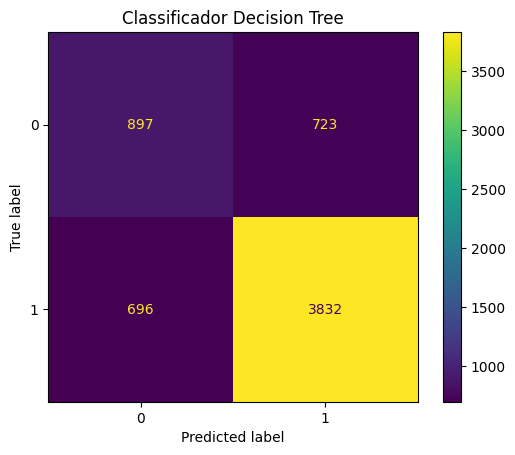

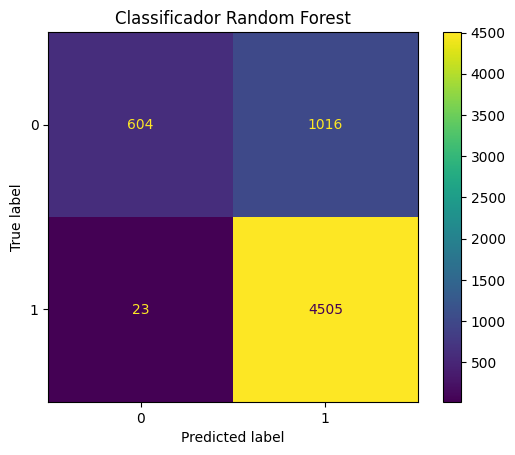

In [22]:
cm = confusion_matrix(y_test, decTree_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Classificador Decision Tree")
plt.show()
cm = confusion_matrix(y_test, ranForest_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Classificador Random Forest")
plt.show()

In [23]:
# Avaliacao

print("Decision Tree Classifier")
print( classification_report( y_test, decTree_pred ) )
print("Random Forest Classifier")
print( classification_report( y_test, ranForest_pred ) )

Decision Tree Classifier
                 precision    recall  f1-score   support

Negative Rating       0.56      0.55      0.56      1620
Positive Rating       0.84      0.85      0.84      4528

       accuracy                           0.77      6148
      macro avg       0.70      0.70      0.70      6148
   weighted avg       0.77      0.77      0.77      6148

Random Forest Classifier
                 precision    recall  f1-score   support

Negative Rating       0.96      0.37      0.54      1620
Positive Rating       0.82      0.99      0.90      4528

       accuracy                           0.83      6148
      macro avg       0.89      0.68      0.72      6148
   weighted avg       0.85      0.83      0.80      6148



Portanto, conclui-se que o modelo Random Forest possui uma aderência melhor à esta base de dados.   
porém, devido ao desbalanceamento das amostras (~75% de classificações positivas), o modelo tem um score melhor quando tentamos predizer classificações positivas. 